In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth


%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [6]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2
C_0 = 279.51
F_2x= 3.71
C_0=C_0
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

C_minus_CH4,T_minus_CH4,RF_minus_CH4,M_minus_CH4,N_minus_CH4,MK_gas_minus_CH4,db_minus_CH4,tau_M_minus_CH4,tau_N_minus_CH4 = FAIR_model(
                            emissions=emissions,N_emissions=N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

C_minus_N2O,T_minus_N2O,RF_minus_N2O,M_minus_N2O,N_minus_N2O,MK_gas_minus_N2O,db_minus_N2O,tau_M_minus_N2O,tau_N_minus_N2O = FAIR_model(
                            emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

C_minus_CO2,T_minus_CO2,RF_minus_CO2,M_minus_CO2,N_minus_CO2,MK_gas_minus_CO2,db_minus_CO2,tau_M_minus_CO2,tau_N_minus_CO2 = FAIR_model(
                            emissions = np.zeros(len(other_rf)), M_emissions=M_emissions,N_emissions=N_emissions, other_rf=other_rf,
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
C_nonono,T_0,RF_0,M_0,N_0,MK_gas_0,db_0,tau_M_0,tau_N_0 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

ANTHRO_RF = smooth(RF,5)
ANTHRO_RF_0 = smooth(RF_0,5)
RF_minus_CH4 = smooth(RF_minus_CH4,5)
RF_minus_N2O = smooth(RF_minus_N2O,5)
RF_minus_CO2 = smooth(RF_minus_CO2,5)

CH4_RF_plot = ANTHRO_RF - RF_minus_CH4
CO2_RF_plot = ANTHRO_RF - RF_minus_CO2
N2O_RF_plot = ANTHRO_RF - RF_minus_N2O
other_RF_plot = ANTHRO_RF - CH4_RF_plot - CO2_RF_plot - N2O_RF_plot

ANTHRO_RF_0_plot = ANTHRO_RF_0

In [10]:
# Radiative forcings -> Concentrations

ANTHRO_conc = rf_to_conc(ANTHRO_RF, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_minus_CH4_conc = rf_to_conc(RF_minus_CH4, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_minus_CO2_conc = rf_to_conc(RF_minus_CO2, a = F_2x/np.log(2) , Cpreind = C_0)
ANTHRO_minus_N2O_conc = rf_to_conc(RF_minus_N2O, a = F_2x/np.log(2) , Cpreind = C_0)

ANTHRO_conc_0 = rf_to_conc(ANTHRO_RF_0, Cpreind = C_0)

# The + 278. adds on the Pre-ind CO_2 concentration since differencing two concentrations from rf_to_conc essentially removes
# the required baseline of 278.

#CH4_conc_plot = ANTHRO_conc - ANTHRO_minus_CH4_conc + 278.
#CO2_conc_plot = ANTHRO_conc - ANTHRO_minus_CO2_conc + 278.
#N2O_conc_plot = ANTHRO_conc - ANTHRO_minus_N2O_conc + 278.
#other_conc_plot = ANTHRO_conc - CH4_conc_plot - CO2_conc_plot - N2O_conc_plot + 278. * 3.

#ATHRO_conc_0_plot = ANTHRO_conc_0

#[CH4_conc_plot,CO2_conc_plot,N2O_conc_plot,other_conc_plot,ANTHRO_conc_0_plot] = np.log(np.array([CH4_conc_plot,
#                                                                                         CO2_conc_plot,
#                                                                                         N2O_conc_plot,
#                                                                                         other_conc_plot,
#                                                                                         ANTHRO_conc_0_plot]) / 278.) * 5.396

In [11]:
# Concentrations -> Emissions

ANTHRO_emms = conc_to_emissions(ANTHRO_conc,T,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
ANTHRO_minus_CH4_emms = conc_to_emissions(ANTHRO_minus_CH4_conc,T_minus_CH4,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
ANTHRO_minus_CO2_emms = conc_to_emissions(ANTHRO_minus_CO2_conc,T_minus_CO2,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
ANTHRO_minus_N2O_emms = conc_to_emissions(ANTHRO_minus_N2O_conc,T_minus_N2O,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

ANTHRO_emms_0 = conc_to_emissions(ANTHRO_conc_0,T_0,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

CO2_CO2_fe_emms = ANTHRO_emms - ANTHRO_minus_CO2_emms
CH4_CO2_fe_emms = ANTHRO_emms - ANTHRO_minus_CH4_emms
N2O_CO2_fe_emms = ANTHRO_emms - ANTHRO_minus_N2O_emms
anthro_CO2_fe_emms = ANTHRO_emms
other_CO2_fe_emms = anthro_CO2_fe_emms - CH4_CO2_fe_emms - CO2_CO2_fe_emms

anthro_CO2_fe_emms_0 = ANTHRO_emms_0


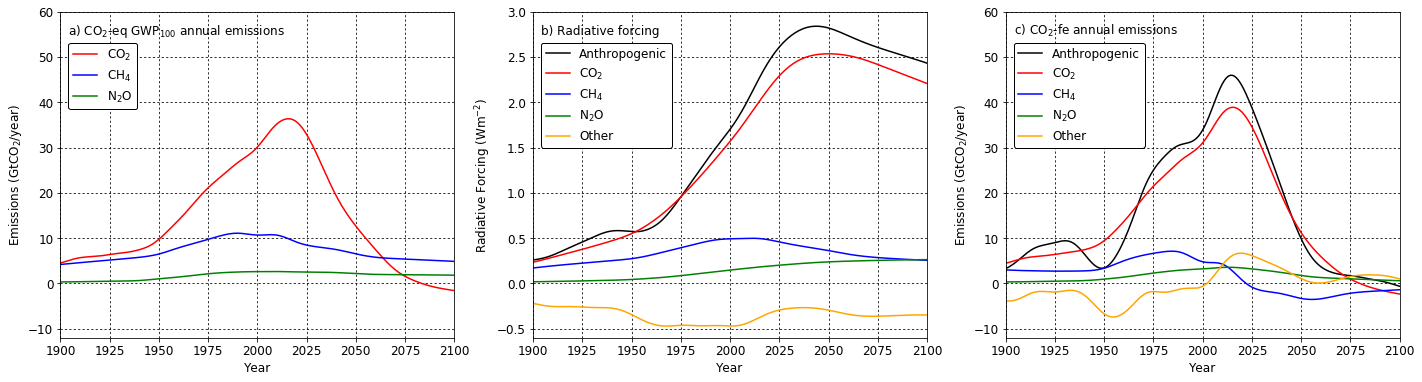

In [12]:
time = np.arange(1765,2501)
CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.
N2O_CO2_eq_GWP = N_emissions * 298./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_fe_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_fe_emms)
cum_N2O_fe = np.cumsum(N2O_CO2_fe_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_fe_emms)
cum_other_fe = np.cumsum(other_CO2_fe_emms)

cum_anthro_fe_0 = np.cumsum(anthro_CO2_fe_emms_0)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
N2O_CO2_eq_GWP_smooth = smooth(N2O_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)
cum_N2O_emms_GWP = np.cumsum(N2O_CO2_eq_GWP_smooth)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
#ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(133)
#ax4 = fig.add_subplot(2,2,4)
ax5 = fig.add_subplot(132)

ax1.grid(linestyle = ':',color = 'black')
ax1.text(1904,55,'a) CO$_2$-eq GWP$_{100}$ annual emissions')
ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.plot(time,N2O_CO2_eq_GWP_smooth,label='N$_2$O',color='green')
ax1.set_ylabel('Emissions (GtCO$_2$/year)')
ax1.set_xlabel('Year')
ax1.legend(loc=(0.02,0.7),framealpha = 1,shadow = False,edgecolor = 'black' )
ax1.set_xlim(1900,2100)
ax1.set_ylim(-12.,60.)

#ax2.plot(time,cum_CO2_emms_GWP,label='CO$_2$',color='red')
#ax2.plot(time,cum_CH4_emms_GWP,label='CH$_4$',color='blue')
#ax2.plot(time,cum_N2O_emms_GWP,label='N$_2$O',color='green')
#ax2.set_ylabel('Emissions (GtCO$_2$)')
#ax2.set_title('Cumulative CO$_2$-eq emissions [GWP$_{100}$]')
#ax2.legend(loc='best')
#ax2.set_xlim(1765,2150)
#ax2.set_ylim(-600.,3700)

ax3.grid(linestyle = ':',color = 'black')
ax3.text(1904,55,'c) CO$_2$-fe annual emissions')
ax3.plot(time,anthro_CO2_fe_emms_0,label='Anthropogenic',color='black')
#ax3.plot(time,anthro_CO2_fe_emms,label='Anthro',color='black')
ax3.plot(time,CO2_CO2_fe_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_fe_emms,label='CH$_4$',color='blue')
ax3.plot(time,N2O_CO2_fe_emms,label='N$_2$O',color='green')
ax3.plot(time,other_CO2_fe_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$/year)')
ax3.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black' )
ax3.set_xlim(1900,2100)
ax3.set_ylim(-12.,60.)

#ax4.plot(time,cum_anthro_fe_0,label='Anthropogenic',color='black')
#ax4.plot(time,cum_anthro_fe,label='Anthro',color='black')
#ax4.plot(time,cum_CO2_fe,label='CO$_2$',color='red')
#ax4.plot(time,cum_CH4_fe,label='CH$_4$',color='blue')
#ax4.plot(time,cum_N2O_fe,label='N$_2$O',color='green')
#ax4.plot(time,cum_other_fe,label='Other',color='orange')
#ax4.set_xlabel('Year')
#ax4.set_ylabel('Emissions (GtCO$_2$)')
#ax4.set_title('Cumulative CO$_2$-fe emissions')
#ax4.legend(loc='best')
#ax4.set_xlim(1765,2150)
#ax4.set_ylim(-600.,3700)

ax5.grid(linestyle = ':',color = 'black')
ax5.text(1904,2.75,'b) Radiative forcing')
ax5.plot(time,ANTHRO_RF_0_plot,label='Anthropogenic',color='black')
#ax5.plot(time,anthro_CO2_fe_emms,label='Anthro',color='black')
ax5.plot(time,CO2_RF_plot,label='CO$_2$',color='red')
ax5.plot(time,CH4_RF_plot,label='CH$_4$',color='blue')
ax5.plot(time,N2O_RF_plot,label='N$_2$O',color='green')
ax5.plot(time,other_RF_plot,label='Other',color='orange')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
#ax5.set_title('Annual CO$_2$ ')
ax5.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black' )
ax5.set_xlim(1900,2100)
ax5.set_ylim(-0.6,3.0)

#ax6 = ax5.twinx()
#ax6.plot(time,ANTHRO_conc_0_plot,'-',label='Anthropogenic',color='black')
#ax6.plot(time,anthro_CO2_fe_emms,label='Anthro',color='black')
#ax6.plot(time,CO2_conc_plot,'-',label='CO$_2$',color='red')
#ax6.plot(time,CH4_conc_plot,'-',label='CH$_4$',color='blue')
#ax6.plot(time,N2O_conc_plot,'-',label='N$_2$O',color='green')
#ax6.plot(time,other_conc_plot,'-',label='Other',color='orange')
#ax6.set_xlabel('Year')
#ax6.set_ylabel('CO$_2$ Equivalent Concentration (ppm)')
#ax6.set_title('Annual CO$_2$ ')
#ax6.legend(loc='upper left')
#ax6.set_xlim(1780,2150)
#ax6.set_ylim(-0.6,3.0)

fig.savefig('./Figures/CO2-e vs CO2-fe Figure MAGICC params_differencing.png',dpi=600)

#ANTHRO - from RCP3 RF data, total anthropogenic emissions calculated by fair inverse model.
#TOTAL - using fair forward co2 and ch4 data, and rcp everything else
#CO2 - co2 emissions calculated forwards from emissions to RF data, and backwards in fair inverse model
#CH4 - ch4 plus co2 emissions calculated from sums of RF calculated using fair forwards and emissions data, then differencing with 
        #just co2 to get methane contribution to emissions (co2-fe)
#OTHER - anthro rf data set from RCP3 minus co2 and ch4 from RCP3 data plus our calculated co2 rf. We then find emissions for this 
        #and remove the contribution from the co2 emissions calculated, and hence find contribution jsut due to other emissions

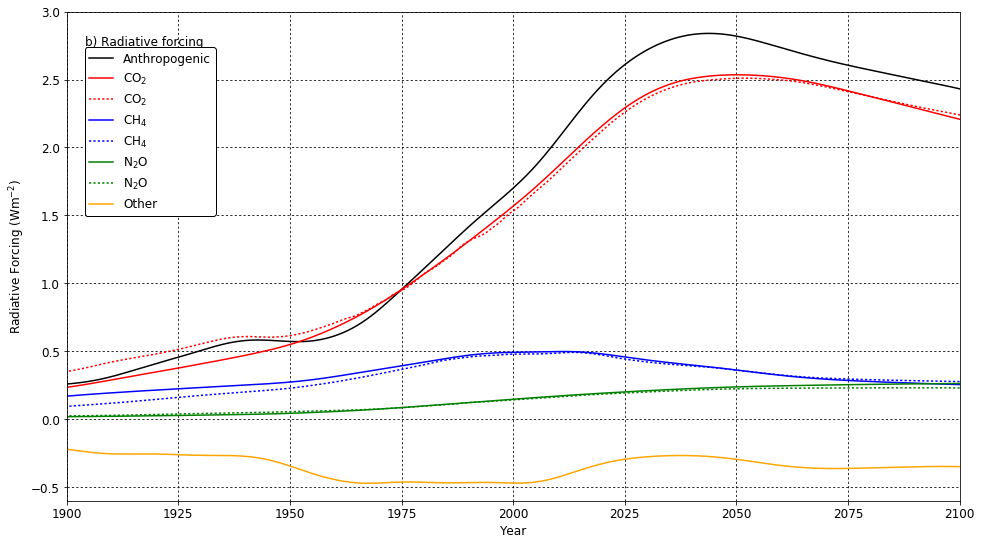

In [10]:
fig1 = plt.figure()
ax5 = fig1.add_subplot(111)

ax5.grid(linestyle = ':',color = 'black')
ax5.text(1904,2.75,'b) Radiative forcing')
ax5.plot(time,ANTHRO_RF_0_plot,label='Anthropogenic',color='black')
#ax5.plot(time,anthro_CO2_fe_emms,label='Anthro',color='black')
ax5.plot(time,CO2_RF_plot,label='CO$_2$',color='red')
ax5.plot(time,forc_data['CO2_RF'],':',label='CO$_2$',color='red')
ax5.plot(time,CH4_RF_plot,label='CH$_4$',color='blue')
ax5.plot(time,forc_data['CH4_RF'],':',label='CH$_4$',color='blue')
ax5.plot(time,N2O_RF_plot,label='N$_2$O',color='green')
ax5.plot(time,forc_data['N2O_RF'],':',label='N$_2$O',color='green')
ax5.plot(time,other_RF_plot,label='Other',color='orange')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
#ax5.set_title('Annual CO$_2$ ')
ax5.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black' )
ax5.set_xlim(1900,2100)
ax5.set_ylim(-0.6,3.0)

fig1.savefig('./Figures/RF comparison (MAGICC Params) vs RCP3PD.png',dpi=600)